<span>
<b>Author:</b> <a href="http://pages.di.unipi.it/ruggieri/">Salvatore Ruggieri</a><br/>
<b>Python version:</b>  3.x<br/>
</span>

In [1]:
# if using Colab
try:
    import google.colab
    is_colab = True
    wdir = 'https://raw.githubusercontent.com/ruggieris/DD/main/'
except:
    is_colab = False
    wdir = '../' # local files
print('Working dir: ', wdir)

Working dir:  ../


In [2]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if is_colab: # (skip if already installed)
    !pip install lime
    !pip install dalex
    !pip install shap
    !pip install pydotplus

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import pydotplus
#import graphviz
import os

# add if needed
if True:
    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [4]:
# Adult dataset
adult = pd.read_csv(wdir+"data/adult_continuous.csv", sep=',', na_values='?')
# remove columns
del adult['fnlwgt'] 
del adult['native-country'] 
# impute missing/outlier values
adult['workclass'] = adult['workclass'].fillna(adult['workclass'].mode()[0])
adult['occupation'] = adult['occupation'].fillna(adult['occupation'].mode()[0])
adult.loc[ adult['capital-gain']==99999, 'capital-gain']= adult['capital-gain'].mean()
# target class
target = 'class'
adult.head()

age         workclass  education  education-num      marital-status  \
0   39         State-gov  Bachelors             13       Never-married   
1   50  Self-emp-not-inc  Bachelors             13  Married-civ-spouse   
2   38           Private    HS-grad              9            Divorced   
3   53           Private       11th              7  Married-civ-spouse   
4   28           Private  Bachelors             13  Married-civ-spouse   

          occupation   relationship   race     sex  capital-gain  \
0       Adm-clerical  Not-in-family  White    Male        2174.0   
1    Exec-managerial        Husband  White    Male           0.0   
2  Handlers-cleaners  Not-in-family  White    Male           0.0   
3  Handlers-cleaners        Husband  Black    Male           0.0   
4     Prof-specialty           Wife  Black  Female           0.0   

   capital-loss  hours-per-week  class  
0             0              40  <=50K  
1             0              13  <=50K  
2             0              40  <=50K  
3             0              40  <=50K  
4             0              40  <=50K

In [5]:
# Encode categorical values into numbers
from sklearn.preprocessing import LabelEncoder

cat = adult.select_dtypes('object').columns
df = pd.DataFrame()
encoders = dict()
for col in adult.columns:
    if col in cat:
        col_encoder = LabelEncoder()
        df[col] = col_encoder.fit_transform(adult[col])
        df[col] = df[col].astype('category')
        encoders[col] = col_encoder
    else:
        df[col] = adult[col]
print(encoders['class'].classes_)
# categorical and numerical and predictive atts 
categorical = [c for c in cat if c!=target]
cat2pos = {f:i for i, f in enumerate(df.columns) if f in categorical} 
categorical_pos = list(cat2pos.values()) # categorical variable positions
numerical = [c for c in df.columns if c!=target and c not in set(categorical)]
atts = [c for c in df.columns if c!=target]
df.head()

['<=50K' '>50K']


age workclass education  education-num marital-status occupation  \
0   39         6         9             13              4          0   
1   50         5         9             13              2          3   
2   38         3        11              9              0          5   
3   53         3         1              7              2          5   
4   28         3         9             13              2          9   

  relationship race sex  capital-gain  capital-loss  hours-per-week class  
0            1    4   1        2174.0             0              40     0  
1            0    4   1           0.0             0              13     0  
2            1    4   1           0.0             0              40     0  
3            0    2   1           0.0             0              40     0  
4            5    2   0           0.0             0              40     0

In [6]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer([("enc", OneHotEncoder(), categorical_pos)], remainder = 'passthrough')

preprocess.fit(df[atts])
# decode back column names
def mapf(f):
    if f[:3]=='rem':
        return f[11:]
    f = f[5:]
    pos = f.find('_')
    return f[:pos]+'='+encoders[f[:pos]].classes_[int(f[pos+1:])]


print(preprocess.get_feature_names_out())
fnames = [mapf(f) for f in preprocess.get_feature_names_out() if f!=target]
print(fnames)

['enc__workclass_0' 'enc__workclass_1' 'enc__workclass_2'
 'enc__workclass_3' 'enc__workclass_4' 'enc__workclass_5'
 'enc__workclass_6' 'enc__workclass_7' 'enc__education_0'
 'enc__education_1' 'enc__education_2' 'enc__education_3'
 'enc__education_4' 'enc__education_5' 'enc__education_6'
 'enc__education_7' 'enc__education_8' 'enc__education_9'
 'enc__education_10' 'enc__education_11' 'enc__education_12'
 'enc__education_13' 'enc__education_14' 'enc__education_15'
 'enc__marital-status_0' 'enc__marital-status_1' 'enc__marital-status_2'
 'enc__marital-status_3' 'enc__marital-status_4' 'enc__marital-status_5'
 'enc__marital-status_6' 'enc__occupation_0' 'enc__occupation_1'
 'enc__occupation_2' 'enc__occupation_3' 'enc__occupation_4'
 'enc__occupation_5' 'enc__occupation_6' 'enc__occupation_7'
 'enc__occupation_8' 'enc__occupation_9' 'enc__occupation_10'
 'enc__occupation_11' 'enc__occupation_12' 'enc__occupation_13'
 'enc__relationship_0' 'enc__relationship_1' 'enc__relationship_2'
 'en

In [7]:
# black box model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

bb = make_pipeline(preprocess, GradientBoostingClassifier(n_estimators=100))

# Part I: Global model explanations

In [8]:
# training-test split 60%-40%
from sklearn.model_selection import train_test_split

X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [9]:
# black box training
from sklearn.metrics import accuracy_score, f1_score

bb.fit(X_train, y_train)
y_pred = bb.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('F1-score: {:.4f}'.format(f1_score(y_test, y_pred)))

Accuracy: 0.8680
F1-score: 0.6852


In [10]:
# surrogate model assuming to know the training data
from sklearn.tree import DecisionTreeClassifier

sm = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=3))
sm.fit(X_train, bb.predict(X_train))
sm_pred = sm.predict(X_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, sm_pred)))
print('F1-score: {:.4f}'.format(f1_score(y_test, sm_pred)))
print('Fidelity: {:.4f}'.format(accuracy_score(y_pred, sm_pred)))

Accuracy: 0.8468
F1-score: 0.6240
Fidelity: 0.9403


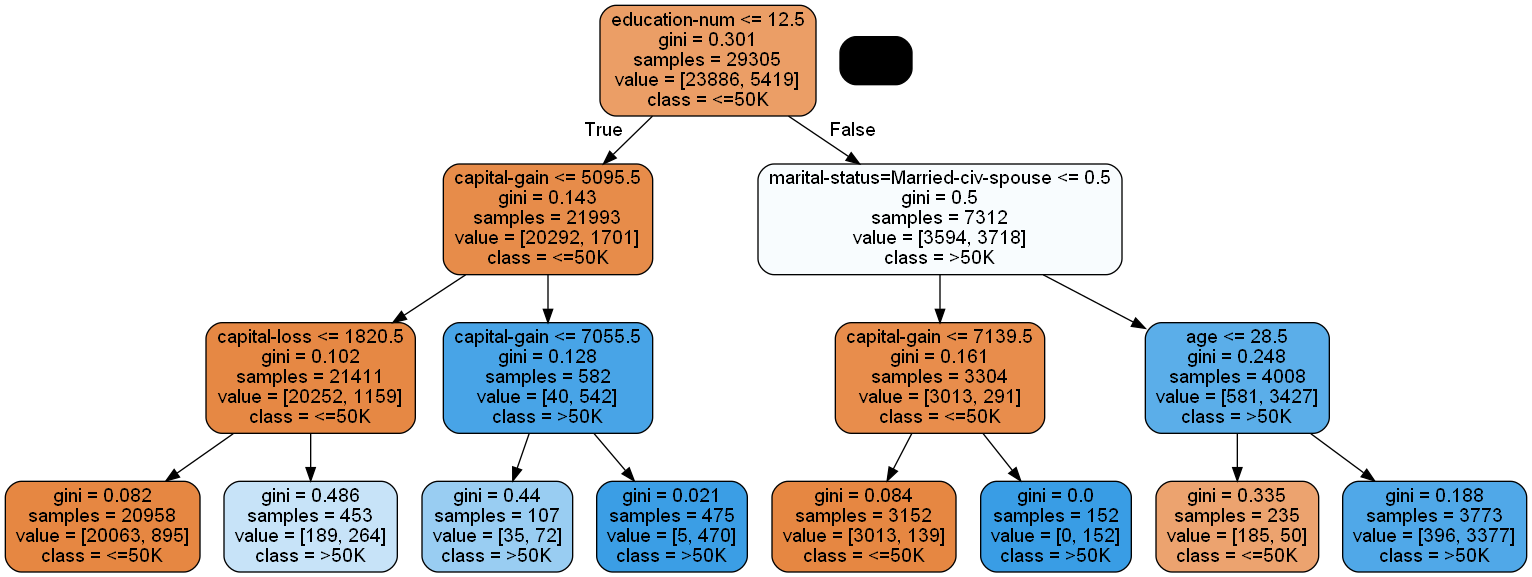

In [11]:
# visualize surrogate model
from sklearn import tree
from IPython.display import Image

dot_data = tree.export_graphviz(sm[1], out_file=None, feature_names=fnames, 
             class_names=encoders['class'].classes_, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [12]:
# surrogate model assuming NOT to know the training data
# use half of the test data for training surrogate model
half = int(len(X_test)/2) 
X_surr_train = X_test[:half]
X_surr_test = X_test[half:]
sm.fit(X_surr_train, bb.predict(X_surr_train))

sm_pred = sm.predict(X_surr_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test[half:], sm_pred)))
print('F1-score: {:.4f}'.format(f1_score(y_test[half:], sm_pred)))
print('Fidelity: {:.4f}'.format(accuracy_score(y_pred[half:], sm_pred)))

Accuracy: 0.8466
F1-score: 0.6124
Fidelity: 0.9432


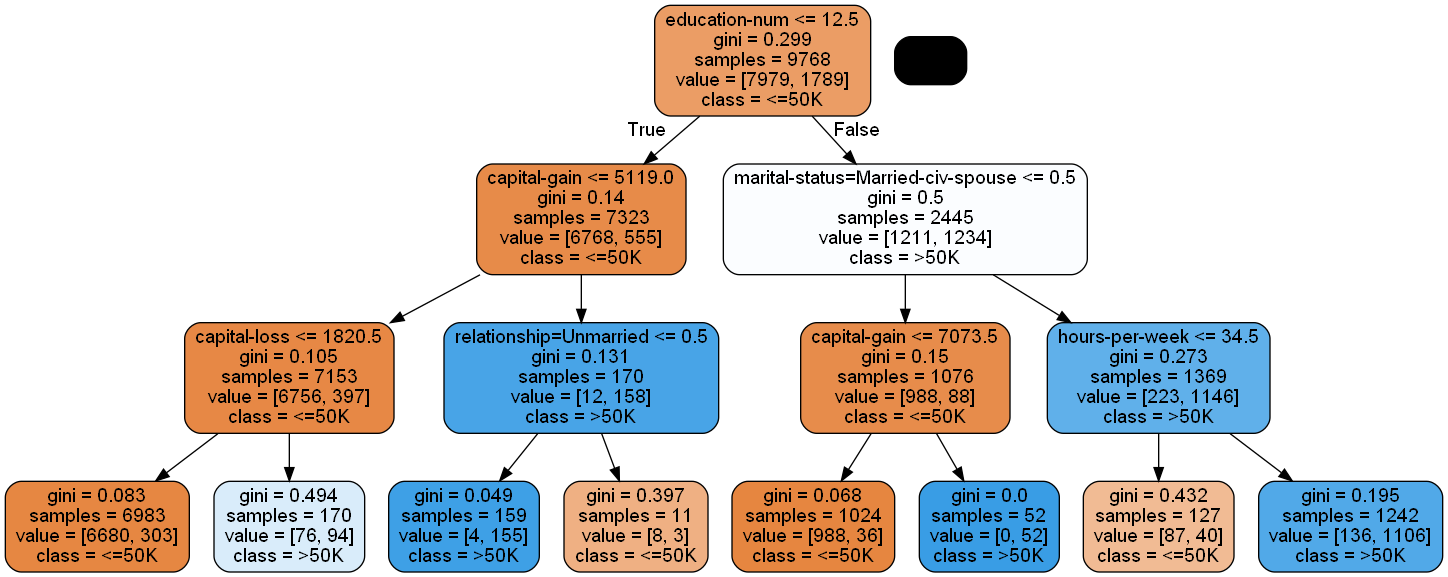

In [13]:
# visualize surrogate model
dot_data = tree.export_graphviz(sm[1], out_file=None, feature_names=fnames,  
             class_names=encoders['class'].classes_, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Part II: Outcome explanations

In [14]:
# LIME
from lime.lime_tabular import LimeTabularExplainer

# LimeTabularExplainer 
lime_explainer = LimeTabularExplainer(X_test.to_numpy(), # numpy dataset
                    feature_names=X_test.columns, # column names
                    class_names=encoders['class'].classes_,  # class names
                    categorical_features=categorical_pos,
                    categorical_names={cat2pos[f]:encoders[f].classes_ for f in categorical}, # categorical variable value names
                    discretize_continuous=False)

In [15]:
# explain instance
x = X_test.iloc[3]
print(x)
predict_fn = lambda x: bb.predict_proba(x).astype(float)
exp = lime_explainer.explain_instance(x, predict_fn)
# as attribute, weight
exp.local_exp

age               32.0
workclass          3.0
education          9.0
education-num     13.0
marital-status     0.0
occupation         9.0
relationship       4.0
race               4.0
sex                0.0
capital-gain       0.0
capital-loss       0.0
hours-per-week    32.0
Name: 18217, dtype: float64


D:\FILES\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


{1: [(4, -0.11295734740219769),
  (3, 0.07995639582870456),
  (11, 0.057485597318326635),
  (0, 0.04946201040163396),
  (8, -0.029705101785838767),
  (9, 0.0247138656039148),
  (5, 0.007673606066697325),
  (6, -0.005912010295314914),
  (1, -0.004141760728515057),
  (7, 0.003484616654352079)]}

In [16]:
exp.show_in_notebook()

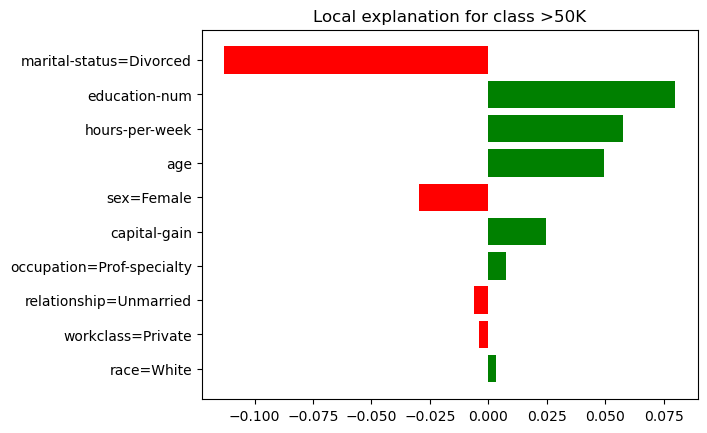

In [17]:
fig = exp.as_pyplot_figure()

In [18]:
# Break-down plots
import dalex as dx

exp = dx.Explainer(bb, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 29305 rows 12 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 29305 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000002093CE2BAF0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.004, mean = 0.239, max = 0.986
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)


D:\FILES\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


  -> residuals         : min = -0.974, mean = -2.95e-05, max = 0.991
  -> model_info        : package sklearn

A new explainer has been created!


In [19]:
# explaning an instance
x = X_test.iloc[3].values
bd_inst = exp.predict_parts(x, type='break_down')
# plotted as attribute=<int>, to get attribute=<value> need to re-train on adult instead of df
bd_inst.plot()

In [20]:
# SHAP using Dalex
shap = exp.predict_parts(x, type = 'shap', B=5)
shap.plot()

In [21]:
# SHAP package
import shap

shap.initjs()
predict_fn = lambda x: bb.predict_proba(x)[:, 1]
med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))
shap_explainer = shap.KernelExplainer(predict_fn, med)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


X does not have valid feature names, but OneHotEncoder was fitted with feature names


In [22]:
shap.initjs() # this is needed for colab
x = X_test.iloc[3].values
shap_values_single = shap_explainer.shap_values(x)
shap.force_plot(shap_explainer.expected_value, shap_values_single, features=x, feature_names=X_test.columns)

X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names


In [23]:
# Ceteris Paribus plots using Dalex
cp = exp.predict_profile(x)
cp.plot(variables=numerical, variable_type = "numerical")
cp.plot(variables=categorical, variable_type = "categorical")

Calculating ceteris paribus: 100%|█████████████████████████████████████████████████████| 12/12 [00:00<00:00, 99.29it/s]


# Part III: Model inspection

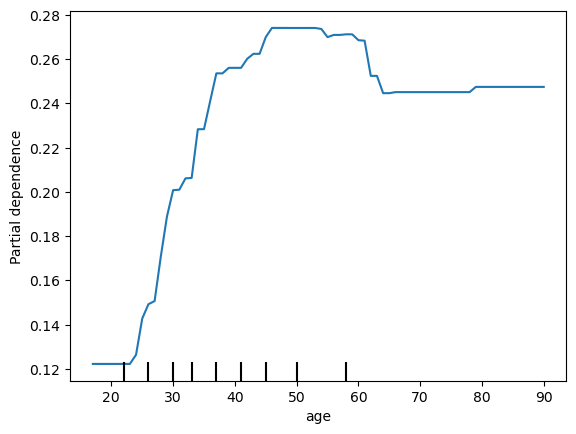

In [24]:
# model inspection: PDP
from sklearn.inspection import PartialDependenceDisplay
# age
PartialDependenceDisplay.from_estimator(bb, X_test, ['age'])

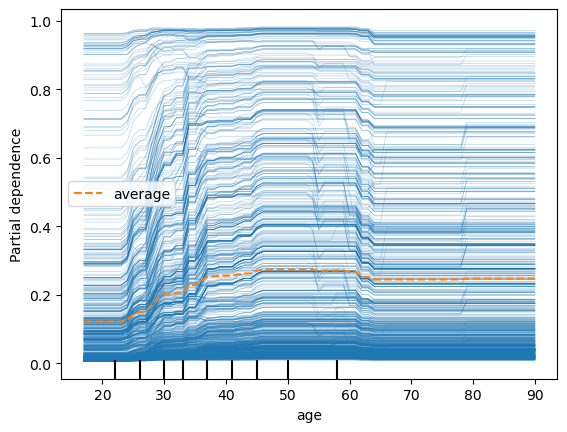

In [25]:
# ICE
PartialDependenceDisplay.from_estimator(bb, X_test, ['age'], kind='both')

In [26]:
# PDP plot using DALEX
pdp = exp.model_profile(type='partial', variables=['age'])
pdp.plot()

Calculating ceteris paribus: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.38it/s]
